# Meteo 515 – Assignment 2 – Parametric Distributions
*Part 2 – Examining Marshall–Palmer fits to a rain drop size distribution (DSD)*

The data are from a 2-D video disdrometer in the western Pacific on 02-Jan-15

In [1]:
from __future__ import division, print_function
#import datetime as dt

import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
#import pandas as pd
from scipy.optimize import curve_fit
#import scipy.stats as ss
#import statsmodels.api as sm

In [2]:
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

## Load the data
using [netcdf4-python](http://unidata.github.io/netcdf4-python/) from [Unidata](https://www.unidata.ucar.edu/)

In [3]:
fname = './data/twpvdisC3.b1.20150102.000000.cdf'
d = Dataset(fname)

base_time = d['base_time']  # seconds since 1970-1-1 0:00:00 0:00
time_offset = d['time_offset']  # same as time...
time = d['time']  # seconds since base time 
assert( np.all(time[:] == time_offset[:]) )
t_dt = num2date(time[:], time.units)  # create datetimes

drop_diameter = d['drop_diameter']
num_density = d['num_density']

intercept_param = d['intercept_parameter']
slope_param = d['slope_parameter']

## a) DSD at chosen minute
Here, we choose the time at which the sum of the larger bins is maximized. 

The simpler Marshall–Palmer fit that we will use for our binned drop number density vs. drop diameter data has the form
\begin{equation}
n(D) = n_0 e^{-\lambda D}
\end{equation}
where $n(D)$ is the number density of raindrops of size $D$ (technically in the size range $[D, D+dD]$), $n_0$ is called the intercept parameter, and $\lambda$ is called the slope parameter. $n(D)$ is also called the drop size distribution (function). 

## b) More complex fit
The more complex fit we will use has the form
\begin{equation}
n(D) = n_0 D^\mu e^{-\lambda D}
\end{equation}
which has an added 3rd parameter, $\mu$. Note that the $k$-th moment of the drop size distribution $n(D)$ is given by $M_k = \int_0^\infty n(D) \, D^k \, dD$


<div class="alert alert-info">

**Note:** in the assignment $N$ is used for number concentration, but I prefer $n$ for number concentration and $N$ for a total particle count. 
</div>

In [4]:
def ND3(D, N_0, mu, lamb):
    """More complex Marshall Palmer number density -- drop size relation"""
    return N_0 * D**mu * np.exp(-lamb*D)

<IPython.core.display.Javascript object>


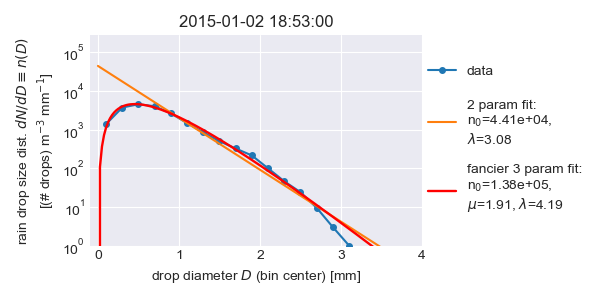

In [5]:
i_t_choice = np.argmax(num_density[:,10:].sum(axis=1))
t_choice = t_dt[i_t_choice]

Dplot = np.linspace(0, 10, 400)

f1, a = plt.subplots(figsize=(6, 3.0), num='dsd')

a.semilogy(drop_diameter[:], num_density[i_t_choice], 'o-', ms=4, label='data')  # the data

a.semilogy(Dplot, intercept_param[i_t_choice]*np.exp(-slope_param[i_t_choice]*Dplot), 
           label='2 param fit:\nn$_0$=%.3g,\n$\lambda$=%.3g' % (intercept_param[i_t_choice], slope_param[i_t_choice]))  # the exp fit

popt, pcov = curve_fit(ND3, drop_diameter[:], num_density[i_t_choice],
                          p0=(1e5, 1, 1), xtol=1e-10)

a.plot(Dplot, ND3(Dplot, *popt), 'r-', lw=1.7,
       label='fancier 3 param fit:\nn$_0$=%.3g,\n$\mu$=%.3g, $\lambda$=%.3g' % tuple(popt))

a.set_xlabel('drop diameter $D$ (bin center) [{:s}]'.format(drop_diameter.units))
a.set_xlim((-0.1, 4))
a.set_ylabel('rain drop size dist. $dN/dD \equiv n(D)$\n[{:s}]'.format('(# drops) m$^{-3}$ mm$^{-1}$'))   #num_density.units))
a.set_ylim(ymin=num_density[i_t_choice][num_density[i_t_choice] > 0].min())  # must be a cleaner way to do this... 
a.set_title(str(t_choice)[:19])  # don't care about sub-second
a.legend(loc='center left', bbox_to_anchor=(0.98, 0.5), labelspacing=1.5)

f1.tight_layout();

### Discussion:

We can see (easily with the log y-axis) that the simpler fit is not able to capture the distribution behavior at the edges, and in fact is unphysical (has a nonzero value at $D=0$). The 3 parameter fit captures the shape much better, although does not quite capture the sharpness of the changes at higher $D$'s. 

## Save figures locally
Probably a silly thing for a Jupyter Notebook to do but whatever

Put the code in a cell and run it to save the figs to local dir 'figs'.
```python
#> save figs; requires that the 'figs' dir exists..
for n in plt.get_fignums():
    f = plt.figure(n)
    f.savefig('./figs/hw2p2_{:s}.pdf'.format(f.get_label()), 
        transparent=False, 
        bbox_inches='tight', pad_inches=0.05,
        )
```